In [1]:
import pandas as pd
import os
import pytz

In [2]:
import numpy as np
import seaborn as sns
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

sns.set()

# 그래프 기본 설정
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 실제 TTF 파일 경로 (예: 나눔고딕)
font_path = '/content/drive/MyDrive/NanumFontSetup_TTF_ALL/NanumGothic.ttf'

# 폰트 등록 및 적용
font_name = fm.FontProperties(fname=font_path).get_name()
fm.fontManager.addfont(font_path)
mpl.rc('font', family=font_name)

In [3]:
notop_one_df = pd.read_parquet('/content/drive/MyDrive/data/noTop3_one_time_buyers_all_events.parquet')

### 카테고리 3 결측치 처리

In [4]:
# category_lvl3가 결측치인 경우 category_lvl2로 대체
notop_one_df['category_lvl3'] = notop_one_df['category_lvl3'].fillna(notop_one_df['category_lvl2'])

# 분석 목표:
고객 재구매 유도 통한 고객 리텐션 향상

데이터 분석 목표: 1회 구매자 vs 2회 이상 구매자 나누어 분석 후, 재구매 요인 분석과 재구매 유도 방안 도출 (재구매하는 안 하는 이유와 재구매하는 이유 분석)

# 구매 가격 분포

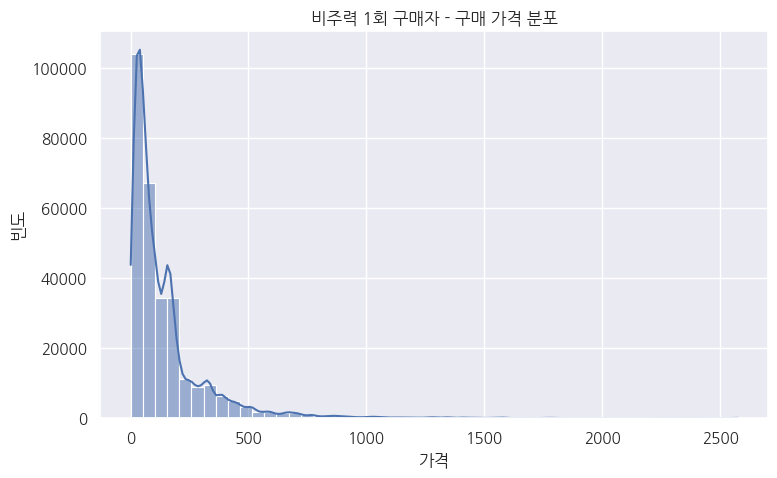

In [5]:
# 구매 이벤트만 추출
purchase_df = notop_one_df[notop_one_df['event_type'] == 'purchase']

# 가격 분포
plt.figure(figsize=(8, 5))
sns.histplot(purchase_df['price'], bins=50, kde=True)
plt.title('비주력 1회 구매자 - 구매 가격 분포')
plt.xlabel('가격')
plt.ylabel('빈도')
plt.tight_layout()
plt.show()

# 가격 구간별 전환율

In [6]:
# 1. 가격 구간 나누기 (10만원 단위, 필요시 조정 가능)
# 올바른 bins와 labels 정의
bins = [0, 100, 200, 300, 400, 500, 1000, float('inf')]  # 8개 → 7개 구간
labels = ['0~100', '100~200', '200~300', '300~400', '400~500', '500~1000', '1000+']  # 7개

# 가격 구간 생성
notop_one_df['price_bin'] = pd.cut(notop_one_df['price'], bins=bins, labels=labels, right=False)


# 2. 구매, 조회 이벤트만 나누기
purchase_df = notop_one_df[notop_one_df['event_type'] == 'purchase']
view_df = notop_one_df[notop_one_df['event_type'] == 'view']

# 3. 가격 구간별 이벤트 수 집계
purchase_stats = purchase_df['price_bin'].value_counts().sort_index().reset_index()
purchase_stats.columns = ['price_bin', 'purchase_count']

view_stats = view_df['price_bin'].value_counts().sort_index().reset_index()
view_stats.columns = ['price_bin', 'view_count']

# 4. 병합 및 전환율 계산
price_group_stats = pd.merge(purchase_stats, view_stats, on='price_bin', how='outer')

# 숫자 컬럼만 골라서 NaN을 0으로 대체
numeric_cols = ['purchase_count', 'view_count']
price_group_stats[numeric_cols] = price_group_stats[numeric_cols].fillna(0)

# 전환율 계산
price_group_stats['conversion_rate'] = price_group_stats['purchase_count'] / price_group_stats['view_count']

# 결과 확인
print(price_group_stats)

  price_bin  purchase_count  view_count  conversion_rate
0     0~100          162184     6407887         0.025310
1   100~200           75062     2514303         0.029854
2   200~300           20401      904981         0.022543
3   300~400           16821      662958         0.025373
4   400~500            8174      397309         0.020573
5  500~1000           11022      732888         0.015039
6     1000+            2954      300777         0.009821


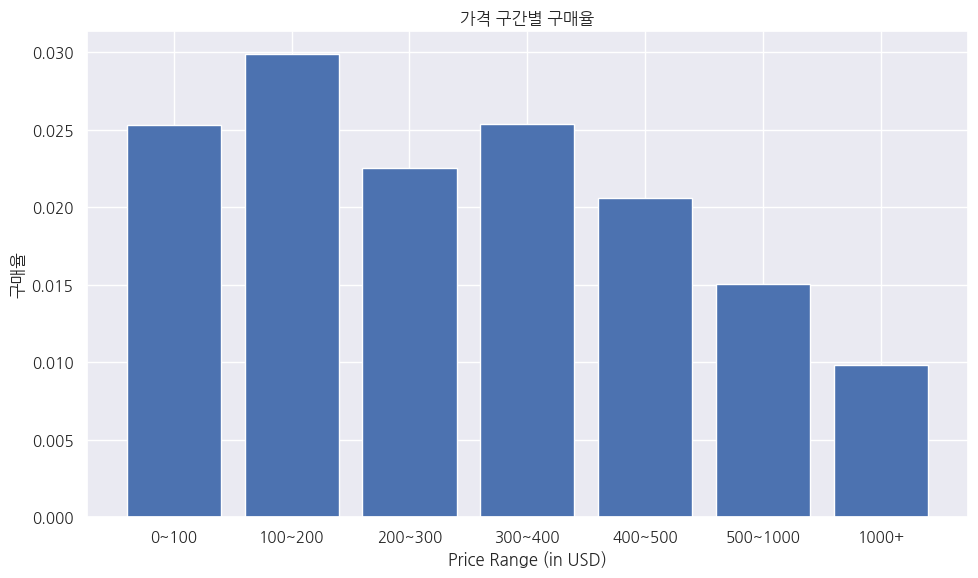

In [7]:
plt.figure(figsize=(10, 6))
plt.bar(price_group_stats['price_bin'].astype(str), price_group_stats['conversion_rate'])
plt.title('가격 구간별 전환율')
plt.xlabel('Price Range (in USD)')
plt.ylabel('전환율')
plt.tight_layout()
plt.show()

# 카테고리 레벨3별 전환 퍼널 분석(전환율)

In [8]:
# 1. 이벤트별 필터링
views = notop_one_df[notop_one_df['event_type'] == 'view']
carts = notop_one_df[notop_one_df['event_type'] == 'cart']
purchases = notop_one_df[notop_one_df['event_type'] == 'purchase']

# 2. 상품별 이벤트 수 집계
view_counts = views.groupby('product_id').size().reset_index(name='view_count')
cart_counts = carts.groupby('product_id').size().reset_index(name='cart_count')
purchase_counts = purchases.groupby('product_id').size().reset_index(name='purchase_count')

# 3. 병합
product_stats = view_counts.merge(cart_counts, on='product_id', how='outer')
product_stats = product_stats.merge(purchase_counts, on='product_id', how='outer')
product_stats.fillna(0, inplace=True)

# 4. 퍼널 전환율 계산
product_stats['view_to_cart_rate'] = product_stats['cart_count'] / product_stats['view_count']
product_stats['cart_to_purchase_rate'] = product_stats['purchase_count'] / product_stats['cart_count']
product_stats['view_to_purchase_rate'] = product_stats['purchase_count'] / product_stats['view_count']

# 5. 상품 정보 결합 (선택)
product_stats = pd.merge(
    product_stats,
    notop_one_df[['product_id', 'category_lvl1', 'category_lvl2', 'category_lvl3']].drop_duplicates(),
    on='product_id', how='left'
)

# 6. 결과 확인 (view 수 기준으로 필터링하여 너무 적은 데이터 제거 가능)
product_stats_filtered = product_stats[product_stats['view_count'] >= 30]
print(product_stats_filtered[['product_id', 'category_lvl3', 'view_to_cart_rate', 'cart_to_purchase_rate', 'view_to_purchase_rate']].sort_values(by='view_to_purchase_rate', ascending=False).head(10))

        product_id category_lvl3  view_to_cart_rate  cart_to_purchase_rate  \
56276     22500122         table           0.322581               0.700000   
147688   100096149         scarf           0.243243               0.777778   
33731     12720351       desktop           0.378641               0.487179   
121574   100031619       desktop           0.187500               0.833333   
33553     12710969       desktop           0.318357               0.487903   
137679   100072168         light           0.181818               0.833333   
33672     12717187       desktop           0.303030               0.500000   
165301   100162574         shirt           0.181818               0.833333   
111235   100008552         shoes           0.200000               0.750000   
150719   100102346         scarf           0.264706               0.555556   

        view_to_purchase_rate  
56276                0.225806  
147688               0.189189  
33731                0.184466  
121574       

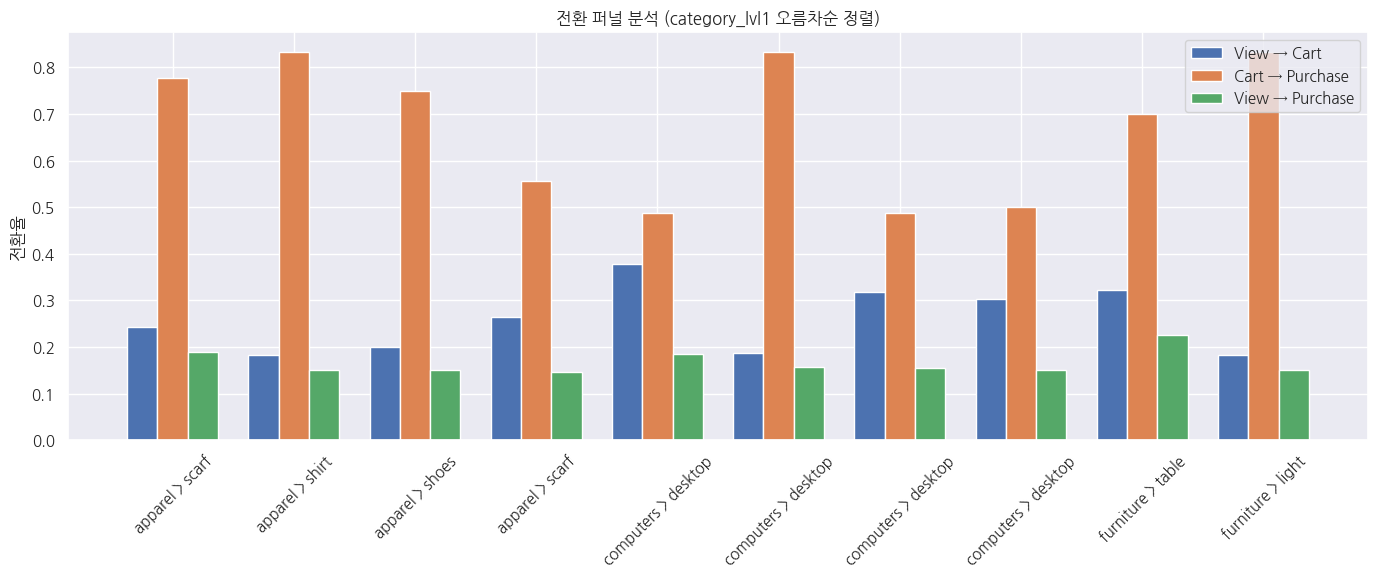

In [9]:
# 1. 새로운 라벨 컬럼 생성
top_funnel = product_stats_filtered.sort_values(by='view_to_purchase_rate', ascending=False).head(10)

top_funnel['category_label'] = top_funnel['category_lvl1'] + ' > ' + top_funnel['category_lvl3']

# 2. category_lvl1 기준 오름차순 정렬
top_funnel_sorted = top_funnel.sort_values(by='category_lvl1')

# 3. 시각화
plt.figure(figsize=(14, 6))
bar_width = 0.25
x = range(len(top_funnel_sorted))

plt.bar(x, top_funnel_sorted['view_to_cart_rate'], width=bar_width, label='View → Cart')
plt.bar([p + bar_width for p in x], top_funnel_sorted['cart_to_purchase_rate'], width=bar_width, label='Cart → Purchase')
plt.bar([p + bar_width*2 for p in x], top_funnel_sorted['view_to_purchase_rate'], width=bar_width, label='View → Purchase')

# 정렬된 라벨 적용
plt.xticks([p + bar_width for p in x], top_funnel_sorted['category_label'], rotation=45)
plt.ylabel('전환율')
plt.title('전환 퍼널 분석 (category_lvl1 오름차순 정렬)')
plt.legend()
plt.tight_layout()
plt.show()

# 카테고리 레벨2, 3별 매출 총합 순위

In [10]:
# 1. 상품별 매출 계산 (price × 건수)
purchase_df = notop_one_df[notop_one_df['event_type'] == 'purchase']
product_revenue = purchase_df.groupby('product_id')['price'].sum().reset_index(name='total_revenue')

# 2. 상품 정보 붙이기 (카테고리 포함)
product_info = notop_one_df[['product_id', 'category_lvl1', 'category_lvl2', 'category_lvl3']].drop_duplicates()
product_revenue = pd.merge(product_revenue, product_info, on='product_id', how='left')

# 3. 매출 총합 상위 10개 상품 출력
top_products = product_revenue.sort_values(by='total_revenue', ascending=False).head(10)
print(top_products)

      product_id  total_revenue category_lvl1 category_lvl2 category_lvl3
3679     4804056     2834950.72         sport       bicycle       bicycle
3856     4804718     1071977.14         sport       bicycle       bicycle
3678     4804055      927169.39         sport       bicycle       bicycle
2550     4100346      802620.31       apparel         shoes         shoes
520      1307073      312829.45     computers      notebook      notebook
2458     4100126      284258.65       apparel         shoes         shoes
4010     5100816      280459.63       apparel         shoes         shoes
3657     4803977      260233.97         sport       bicycle       bicycle
665      1307310      247103.79     computers      notebook      notebook
2459     4100129      221323.99       apparel         shoes         shoes


### 카테고리 레벨 2 매출 상위 10

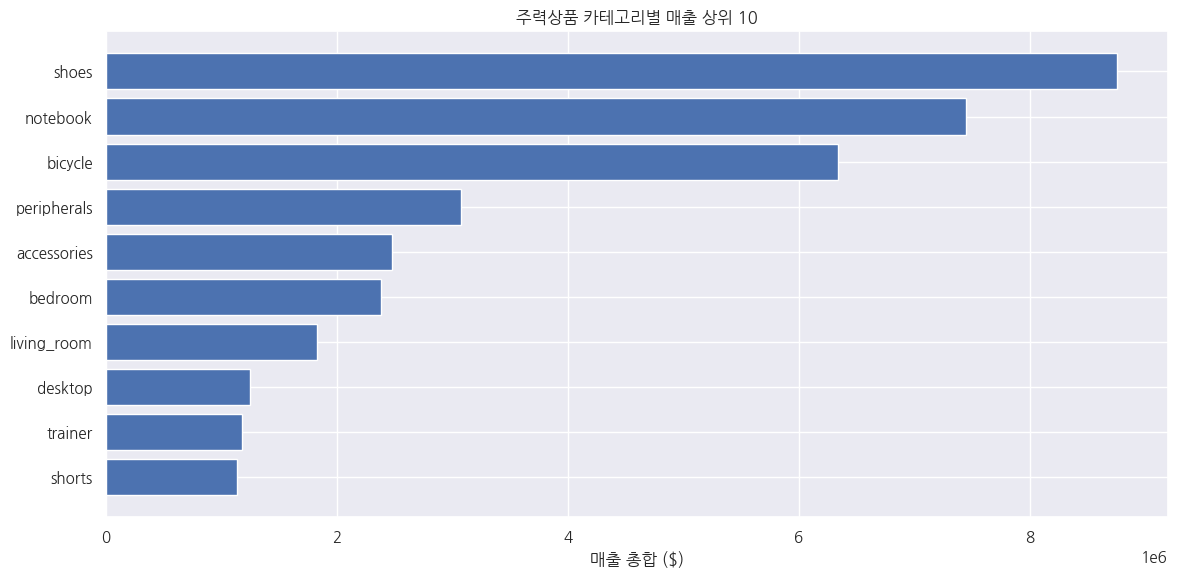

In [11]:
# 4. 카테고리별 매출 총합 (category_lvl2 기준)
category_revenue = purchase_df.groupby('category_lvl2')['price'].sum().reset_index(name='total_revenue')
category_revenue = category_revenue.sort_values(by='total_revenue', ascending=False).head(10)

# 5. 시각화
plt.figure(figsize=(12,6))
plt.barh(category_revenue['category_lvl2'], category_revenue['total_revenue'])
plt.xlabel('매출 총합 ($)')
plt.title('주력상품 카테고리별 매출 상위 10')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 카테고리 레벨 3 매출 상위 10

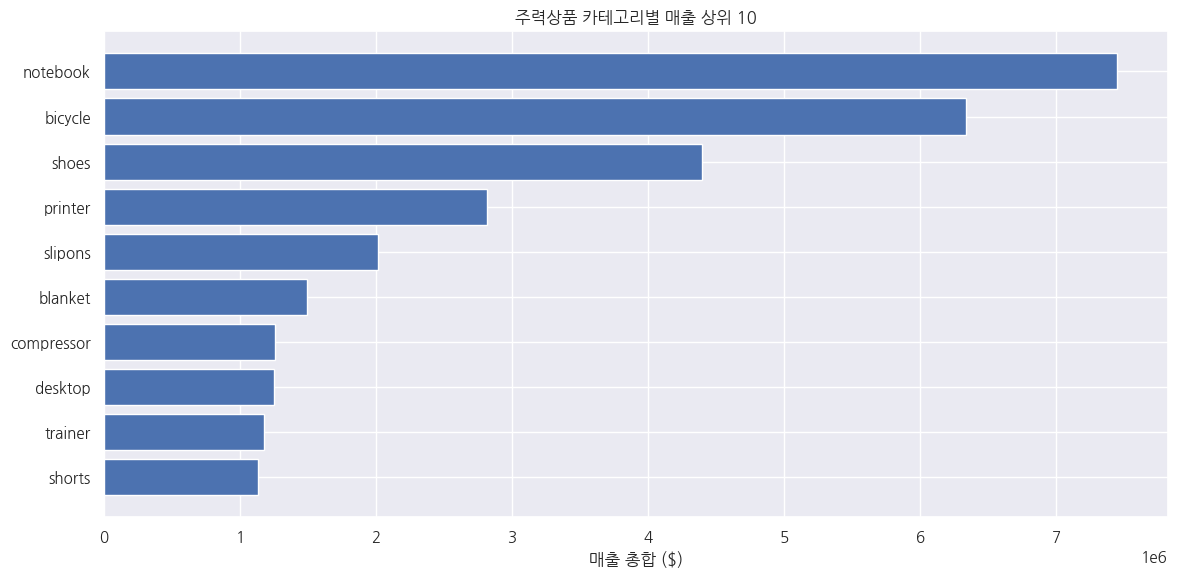

In [12]:
# 4. 카테고리별 매출 총합 (category_lvl3 기준)
category_revenue = purchase_df.groupby('category_lvl3')['price'].sum().reset_index(name='total_revenue')
category_revenue = category_revenue.sort_values(by='total_revenue', ascending=False).head(10)

# 5. 시각화
plt.figure(figsize=(12,6))
plt.barh(category_revenue['category_lvl3'], category_revenue['total_revenue'])
plt.xlabel('매출 총합 ($)')
plt.title('주력상품 카테고리별 매출 상위 10')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()